# Generate GeM annotation

## 1. Import the necessary packages.

In [1]:
# Computer vision
import cv2
import mahotas
import numpy as np

# File handling
import codecs

# GeM generator
from generator import classify, describe, detect_roi, generate_photo, generate_text, load_model, preprocess, project, remove_false_positives, sort_contours

# Jupyter notebook
from IPython.display import Image

## 2. Set up the classifier.

#### Load the pre-trained data and labels.

In [2]:
model = load_model()

## 3. Process the document image.

#### Preprocess the document image.

In [3]:
image, original, filename, filepath = preprocess("test_images/2005-hwy-side_b-5.jpg")

#### Detect regions of interest in the document image.

In [4]:
contours, hierarchy = detect_roi(image)

#### Sort the detected contours.

In [5]:
contours = sort_contours(contours)

#### Classify the detected contours.

In [6]:
cc, ct = classify(contours, image, model)

#### Draw the detected contours for examination.

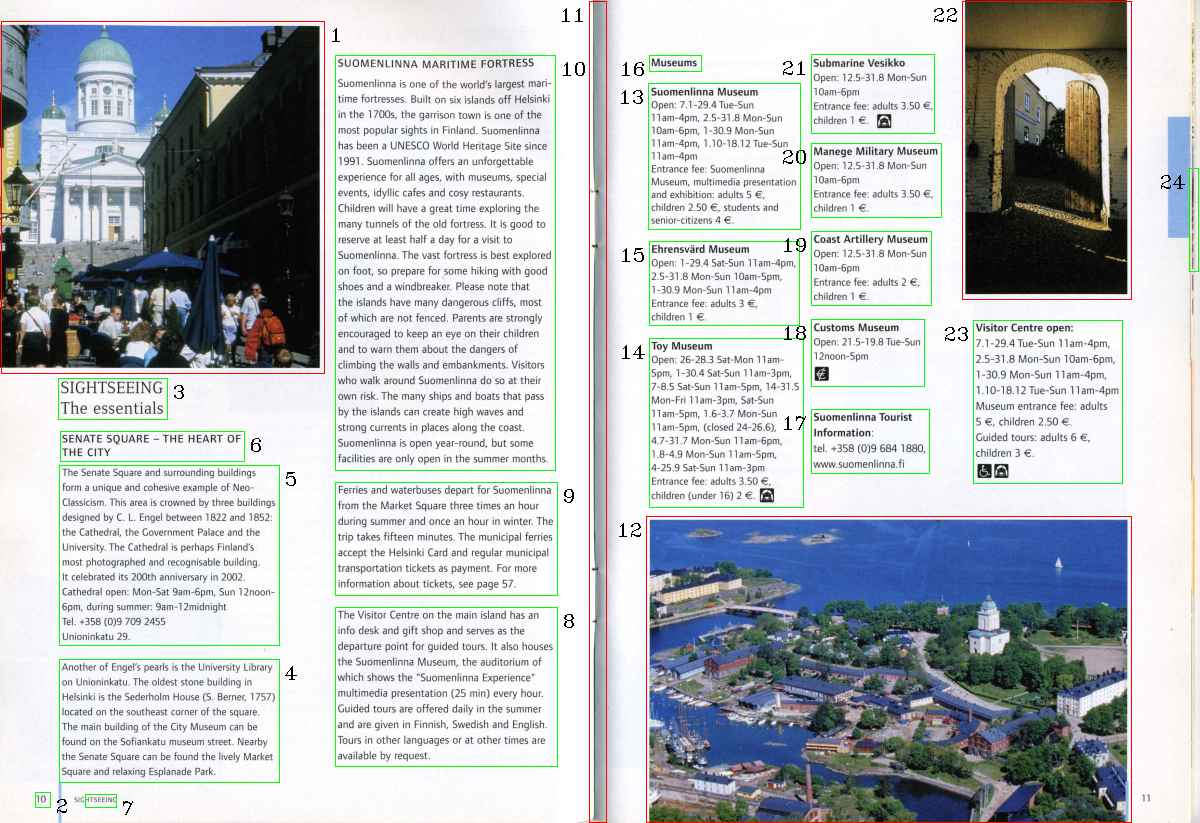

In [7]:
Image(filename="image_contours.png")

#### Mark false positives.

In [8]:
fps = raw_input()
cc, ct = remove_false_positives(fps, cc, ct)

11 24


#### Project the contours on the original high resolution document image.

In [9]:
ratio = project(image, original)

In [10]:
bbox_original = {}

for identifier, contours in cc.items():
    bbox_original[identifier] = int(round(contours[0] * ratio)), int(round(contours[1] * ratio)), int(round(contours[2] * ratio)), int(round(contours[3] * ratio))

In [13]:
oh = original.shape[0]
ow = original.shape[1]

segmentation = []
area_model = []
realization = []

for identifier, bbox in bbox_original.items():
    x, w, y, h = bbox[0], bbox[1], bbox[2] - bbox[0] , bbox[3] - bbox[1]
    print x, w, y, h
    
    #if ct[identifier] == 'text':
        # Generate XML entries
        #lu, sa, re = generate_text(original, x, w, y, h, identifier)
        # Append descriptions to list
        #segmentation.append(lu)
        #area_model.append(sa)
        #realization.append(re)
    #if ct[identifier] == 'photo':
        # Generate XML entries
        #vlu, vsa, vre = generate_photo(original, x, w, y, h, identifier)
        # Append descriptions to list
        #segmentation.append(vlu)
        #area_model.append(vsa)
        #realization.append(vre)

3 61 942 968
102 2316 -58 -2272
170 1105 149 -985
173 1927 470 -1567
173 1360 470 -834
175 1260 363 -1172
249 2322 -158 -2284
980 1775 -331 -1310
980 1409 -331 -1079
980 161 -337 1053
1889 1509 -471 -614
1895 243 -1451 184
1898 988 -1448 -494
1898 705 -1459 -459
1898 161 -1746 -114
2371 1196 -2026 -1009
2371 933 -2041 -737
2371 675 -2020 -459
2371 418 -1991 -202
2371 158 -2011 73
2813 3 -2319 868
2845 936 -2409 -459


## 4. Begin the annotation.

Open the XML file.

In [ ]:
layout_file_name = str(filename) + '-layout-2.xml'
xmlfile = codecs.open(layout_file_name, 'w', 'utf-8')

xml_opening = '<?xml version="1.0" encoding="UTF-8"?>\n\n <gemLayout>\n'

Write preamble.

In [ ]:
xmlfile.write(xml_opening)

In [ ]:
oh = original.shape[0]
ow = original.shape[1]

segmentation = []
area_model = []
realization = []

for num, c in enumerate(contours):
    (x, y, w, h) = cv2.boundingRect(c)
    bounding_box = original[y:y+h, x:x+w]
    features = describe(bounding_box)
    prediction = model.predict(features)[0]
    if prediction == 'text':
        # Draw rectange on original image
        cv2.rectangle(original, (x, y), (x + w, y + h), (0, 0, 255), 1)
        # Generate XML entries
        lu, sa, re = generate_text(original, x, w, y, h, num)
        # Append descriptions to list
        segmentation.append(lu)
        area_model.append(sa)
        realization.append(re)
    if prediction == 'photo':
        # Draw rectange on original image
        cv2.rectangle(original, (x, y), (x + w, y + h), (0, 255, 0), 1)
        # Generate XML entries
        vlu, vsa, vre = generate_photo(original, x, w, y, h, num)
        # Append descriptions to list
        segmentation.append(vlu)
        area_model.append(vsa)
        realization.append(vre)

## 4. Generate the GeM XML file

Generate annotation for layout layer segmentation.

In [ ]:
segmentation_opening = '\t<segmentation>\n'

xmlfile.write("".join(segmentation_opening))

for s in segmentation:
    xmlfile.write("".join(s))
    
segmentation_closing = '\t</segmentation>\n'

xmlfile.write("".join(segmentation_closing))

Generate annotation for area model.

In [ ]:
areamodel_opening = '\t<area-model>\n'

xmlfile.write("".join(areamodel_opening))

for a in area_model:
    xmlfile.write("".join(a))
    
areamodel_closing = '\t</area-model>\n'

xmlfile.write("".join(areamodel_closing))

Generate annotation for realization information.

In [ ]:
realization_opening = '\t<realization>\n'

xmlfile.write("".join(realization_opening))

for r in realization:
    xmlfile.write("".join(r))
    
realization_closing = '\t</realization>\n'

xmlfile.write("".join(realization_closing))

Write closing tag.

In [ ]:
xmlfile_closing = '</gemLayout>'

xmlfile.write("".join(xmlfile_closing))

In [ ]:
xmlfile.close()